In [1]:
import sys

sys.path.append('../tools/')

from monodepth2.infer import load_model
from tracktor_utils import tracker_obj
from tracktor.utils import interpolate
from torchvision.transforms import ToTensor, Compose, Resize, ToPILImage

from monodepth2.infer import infer_depth as monodepth_infer
from statsmodels.nonparametric.kernel_regression import KernelReg
from scipy.signal import savgol_filter

import cv2
import torch
import numpy as np
from PIL import Image

import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
def kalmanfilter(x,p,z,r):
    # p - estimate unceratininty 
    # r - measurement unceratininty ( σ2 )  
    # z - Measured System State

    # Kalman gain calculation
    K =  p/(p+r)
    # estimate current state
    x1 = x + K*(z-x)
    # update current estimate uncertainity
    p1 = (1-K)*p

    return (x1,p1)

In [3]:
tracker = tracker_obj("../tracking_wo_bnw/")

tracker.reset()

In [4]:
cap = cv2.VideoCapture('../samples/mot16.webm')

In [5]:
depth_tracks = {}
depth_tracks_smoothed = {}
depth_tracks_p = {}
depth_tracks_b = {}

def get_depth_and_smoothed(img, inference, tracker, depth_merger='mean'):   
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_pil = Image.fromarray(img)
    
    with torch.no_grad():
        if inference['name'] == 'monodepth':
            depth_map, depth_im = monodepth_infer(inference['encoder'],
                                                  inference['depth_decoder'],
                                                  inference['input_size'],
                                                  img_pil)
            depth_map = depth_map[0, 0] # * 5.4
        else:  # mannequin
            depth_map, depth_im = mannequin_infer(img_pil)
            depth_map = (255 - depth_map) / 7

        
        transforms = Compose([
            Resize((749, 1333)),
            ToTensor(),
        ])
        frame_batch = {
            'img': transforms(img_pil).unsqueeze(0)#.cuda()
        }
        tracker.step(frame_batch)
        results = tracker.get_results()
        results = interpolate(results)
        for t, r in results.items():
            x1, y1, x2, y2 = map(int, r[max(r, key=int)])
            if (x2 - x1) * (y2 - y1) < 900:
                continue
            m = np.zeros_like(depth_map)
            y1 = int(y1 * m.shape[0] / 749)
            y2 = int(y2 * m.shape[0] / 749)

            x1 = int(x1 * m.shape[1] / 1333)
            x2 = int(x2 * m.shape[1] / 1333)

            m[y1:y2, x1:x2] = 1
            person_depth = depth_map * m
            try:
                if depth_merger == 'mean':
                    avg_depth = person_depth[np.where(person_depth != 0)].mean()
                elif depth_merger == 'median': 
                    avg_depth = np.median(person_depth[np.where(person_depth != 0)])
                else:
                    raise Exception("Undefined depth_merger error!")
                x, y = int((x1 + x2) / 2), int((y1 + y2) / 2)

                if t not in depth_tracks:
                    depth_tracks[t] = [avg_depth]
                else: 
                    depth_tracks[t].append(avg_depth)
                    
                avg_depth_s = avg_depth
                p = 1
                if len(depth_tracks[t]) > 1:
                    avg_depth_s = depth_tracks_smoothed[t][-1]
                    p = depth_tracks_p[t][-1]
                
                avg_depth_s, p = kalmanfilter(avg_depth_s, p, avg_depth, 1)
                
                if t not in depth_tracks_smoothed:
                    depth_tracks_smoothed[t] = [avg_depth_s]
                else: 
                    depth_tracks_smoothed[t].append(avg_depth_s)
                    
                if t not in depth_tracks_p:
                    depth_tracks_p[t] = [p]
                else: 
                    depth_tracks_p[t].append(p)
                    
                if t not in depth_tracks_b:
                    depth_tracks_b[t] = [[x1, y1, x2, y2]]
                else: 
                    depth_tracks_b[t].append([x1, y1, x2, y2])
                
            except ValueError as e:
                print(e)
                continue

In [6]:
inference = {'name': 'monodepth'}

encoder, depth_decoder, (feed_width, feed_height) = load_model("mono+stereo_1024x320")
inference['encoder'] = encoder
inference['depth_decoder'] = depth_decoder
inference['input_size'] = (feed_width, feed_height)

-> Loading model from  models/mono+stereo_1024x320
   Loading pretrained encoder
   Loading pretrained decoder


In [7]:
counter = 0
while(cap.isOpened()):
    counter += 1
    ret, frame = cap.read()
    get_depth_and_smoothed(frame, inference, tracker)
    
    if counter > 50 or not ret: 
        break
    
cap.release()

In [8]:
track_id = 3

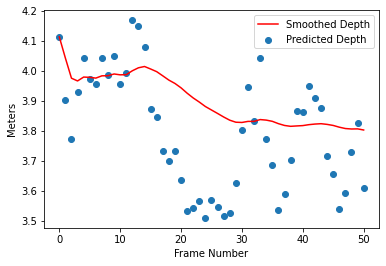

In [9]:
# plt.figure(figsize=(12,12))
plt.ylabel('Meters')
plt.xlabel('Frame Number')
plt.plot(depth_tracks_smoothed[track_id], c='r', label='Smoothed Depth')
plt.scatter(range(len(depth_tracks[track_id])), depth_tracks[track_id], label='Predicted Depth')

plt.legend()
plt.savefig('kalman.pdf', dpi=300)

In [15]:
(np.array(depth_tracks_b[3])[:, 3] - np.array(depth_tracks_b[3])[:, 1]).max()

188

In [16]:
(np.array(depth_tracks_b[3])[:, 2] - np.array(depth_tracks_b[3])[:, 0]).max()

70

In [25]:
cap = cv2.VideoCapture('../samples/mot16.webm')

append_images = []
counter = 0
while(cap.isOpened()):
    
    ret, frame = cap.read()
    
    x1, y1, x2, y2 = depth_tracks_b[3][counter]
    
    img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    img_pil = Image.fromarray(img[y1-45:y1+250, x1-80:x1+150])
    append_images.append(img_pil)
    counter += 1
    
    if counter > 50 or not ret: 
        break
    
cap.release()

In [30]:
append_images[0].save(
    'out.gif', 
    save_all=True, 
    append_images=append_images[1:],
    duration=18
)
